**Goal**

Predict the total energy consumption in kBtu of buildings in Seattle.

In [134]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import data_science_functions as ds
import project_tools as pt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(
    func=np.log1p,
    inverse_func=np.expm1)
identity_transformer = FunctionTransformer(
    func=lambda x: x,
    inverse_func=lambda x: x,
    validate=True
)
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

from math import sqrt

In [3]:
data = pd.read_csv('seattle.csv',
                   index_col='OSEBuildingID')
display(data.head())
data.shape

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,Age,ProportionPrincipalUseType,ProportionSecondaryUseType,ProportionThirdUseType,RiseType,AgeType,energies_sum,energy_ratio,SteamUseProportion,ElectricityProportion,NaturalGasProportion
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,Compliant,NaN,249.98,2.83,96,1.000000,NaN,NaN,Medium,Very_old,7226362.00,1.0,0.28,0.55,0.18
2,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,Compliant,NaN,295.86,2.86,27,0.809918,0.145453,0.044629,Medium,Modern,8387933.00,1.0,0.00,0.39,0.61
3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,Compliant,NaN,2089.28,2.19,54,0.791220,NaN,NaN,High,Old,72587018.00,1.0,0.30,0.68,0.02
5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,Compliant,NaN,286.43,4.67,97,1.000000,NaN,NaN,Medium,Very_old,6794583.25,1.0,0.33,0.41,0.27
8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,Compliant,NaN,505.01,2.88,43,0.703070,0.387339,0.000000,Medium,Modern,14172605.00,1.0,0.00,0.38,0.62


(1484, 51)

In [4]:
# Constant used as target in this notebook.
pt.ENERGY_TARGET

'SiteEnergyUse(kBtu)'

**Table of contents**<a id='toc0_'></a>    
- 1. [One-Hot Encoding](#toc1_)    
  - 1.1. [Primary Property Type](#toc1_1_)    
  - 1.2. [Council District Code](#toc1_2_)    
- 2. [Groups of features](#toc2_)    
- 3. [Preparing target and several algorithm inputs](#toc3_)    
- 4. [Splitting into test and train sets](#toc4_)    
- 5. [Baseline](#toc5_)    
- 6. [Linear regression](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>One-Hot Encoding

## 1.1.  [&#9650;](#toc0_) <a id='toc1_1_'></a>Primary Property Type

In [5]:
# Formatting PPT
print('PRE-FORMATTING :\n')
display(data[pt.PPT].value_counts())
data[pt.PPT] = data[pt.PPT].str.split(' |/|-').str.join('')
print('POST-FORMATTING :\n')
display(data[pt.PPT].value_counts())

PRE-FORMATTING :



Small- and Mid-Sized Office    275
Other                          232
Warehouse                      182
Large Office                   164
Mixed Use Property              98
Retail Store                    82
Hotel                           73
Worship Facility                68
Distribution Center             53
K-12 School                     50
Medical Office                  37
Supermarket / Grocery Store     37
Self-Storage Facility           28
University                      24
Senior Care Community           20
Residence Hall                  20
Refrigerated Warehouse          11
Restaurant                      11
Hospital                         9
Laboratory                       8
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

POST-FORMATTING :



SmallandMidSizedOffice     275
Other                      232
Warehouse                  182
LargeOffice                164
MixedUseProperty            98
RetailStore                 82
Hotel                       73
WorshipFacility             68
DistributionCenter          53
K12School                   50
MedicalOffice               37
SupermarketGroceryStore     37
SelfStorageFacility         28
University                  24
SeniorCareCommunity         20
ResidenceHall               20
RefrigeratedWarehouse       11
Restaurant                  11
Hospital                     9
Laboratory                   8
LowRiseMultifamily           2
Name: PrimaryPropertyType, dtype: int64

In [6]:
data.loc[data[pt.PPT] == 'LowRiseMultifamily', ['LargestPropertyUseType']]

,LargestPropertyUseType
OSEBuildingID,
19445,Multifamily Housing
21481,Multifamily Housing


In [7]:
data = data.drop(data.loc[data[pt.PPT] == 'LowRiseMultifamily'].index, axis=0)
display(data[pt.PPT].value_counts())

SmallandMidSizedOffice     275
Other                      232
Warehouse                  182
LargeOffice                164
MixedUseProperty            98
RetailStore                 82
Hotel                       73
WorshipFacility             68
DistributionCenter          53
K12School                   50
MedicalOffice               37
SupermarketGroceryStore     37
SelfStorageFacility         28
University                  24
SeniorCareCommunity         20
ResidenceHall               20
RefrigeratedWarehouse       11
Restaurant                  11
Hospital                     9
Laboratory                   8
Name: PrimaryPropertyType, dtype: int64

In [8]:
PPT_encoder, data = ds.one_hot_encoding(
        
    data,
    [pt.PPT],
    drop='first'
    
)

## 1.2.  [&#9650;](#toc0_) <a id='toc1_2_'></a>Council District Code

In [9]:
data.CouncilDistrictCode.value_counts()

7    489
2    357
3    174
4    154
5    115
6     99
1     94
Name: CouncilDistrictCode, dtype: int64

In [10]:
geo_encoder, data = ds.one_hot_encoding(
    
    data,
    ['CouncilDistrictCode'],
    drop='first'
    
)
data.shape

(1482, 76)

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Groups of features

In [11]:
# Check one hot encoded features names
data.columns[-25:]

Index(['PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K12School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_LargeOffice', 'PrimaryPropertyType_MedicalOffice',
       'PrimaryPropertyType_MixedUseProperty', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_RefrigeratedWarehouse',
       'PrimaryPropertyType_ResidenceHall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_RetailStore',
       'PrimaryPropertyType_SelfStorageFacility',
       'PrimaryPropertyType_SeniorCareCommunity',
       'PrimaryPropertyType_SmallandMidSizedOffice',
       'PrimaryPropertyType_SupermarketGroceryStore',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_WorshipFacility', 'CouncilDistrictCode_2',
       'CouncilDistrictCode_3', 'CouncilDistrictCode_4',
       'CouncilDistrictCode_5', 'CouncilDistrictCode_6',
       'CouncilDistrictCode_7'],
      dtype='object')

In [12]:
# Preparing groups of features for later convenience
PPT_categories = PPT_encoder.categories_[0]
PPT_fts = ['PrimaryPropertyType_' + cat for cat in PPT_categories[1:]]

geo_categories = geo_encoder.categories_[0]
geo_fts = ['CouncilDistrictCode_' + str(cat) for cat in geo_categories[1:]]

core_fts = [*['PropertyGFABuilding(s)',
             'Age',
             'NumberofBuildings',
             'NumberofFloors',
             'SteamUseProportion',
             'ElectricityProportion',
             'NaturalGasProportion']
             , *PPT_fts]

additional_fts = [*geo_fts, 'ProportionPrincipalUseType']

In [13]:
core_fts

['PropertyGFABuilding(s)',
 'Age',
 'NumberofBuildings',
 'NumberofFloors',
 'SteamUseProportion',
 'ElectricityProportion',
 'NaturalGasProportion',
 'PrimaryPropertyType_Hospital',
 'PrimaryPropertyType_Hotel',
 'PrimaryPropertyType_K12School',
 'PrimaryPropertyType_Laboratory',
 'PrimaryPropertyType_LargeOffice',
 'PrimaryPropertyType_MedicalOffice',
 'PrimaryPropertyType_MixedUseProperty',
 'PrimaryPropertyType_Other',
 'PrimaryPropertyType_RefrigeratedWarehouse',
 'PrimaryPropertyType_ResidenceHall',
 'PrimaryPropertyType_Restaurant',
 'PrimaryPropertyType_RetailStore',
 'PrimaryPropertyType_SelfStorageFacility',
 'PrimaryPropertyType_SeniorCareCommunity',
 'PrimaryPropertyType_SmallandMidSizedOffice',
 'PrimaryPropertyType_SupermarketGroceryStore',
 'PrimaryPropertyType_University',
 'PrimaryPropertyType_Warehouse',
 'PrimaryPropertyType_WorshipFacility']

In [14]:
additional_fts

['CouncilDistrictCode_2',
 'CouncilDistrictCode_3',
 'CouncilDistrictCode_4',
 'CouncilDistrictCode_5',
 'CouncilDistrictCode_6',
 'CouncilDistrictCode_7',
 'ProportionPrincipalUseType']

I might want to come back here, and try to weight the ones of PPT with its proportion.

For that, I might need to map each largest use type(more detailed) with primary type.

And I could do the same with second and third largest use type.

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Preparing target and several algorithm inputs

In [15]:
y = data[pt.ENERGY_TARGET]
X_core = data.loc[:, core_fts]
X_core_with_additional = data.loc[:, [*core_fts, *additional_fts]]
Xs = [X_core,
      X_core_with_additional]

# Chosen regression metrics

In [ ]:
metrics = []

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Splitting into test and train sets

In [46]:
X = X_core
test_size = 0.25
seed = 2
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=test_size,
                                                    random_state=seed) 

In [47]:
X_train.shape

(1111, 26)

# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Baseline

In [48]:
dummy = DummyRegressor(strategy='mean')
ds.CV_evaluation(dummy, X_train, y_train)

DummyRegressor
Cross-validation evaluation results w.r.t the r2 metrics:

    scores on folds: [-0.00114579 -0.00645624 -0.0586586  -0.00011799 -0.00212907]
    mean score: -0.013701537633745797
    std score deviation: 0.02258191168821433


# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>Linear regressions

## OLS minimization

In [49]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler(feature_range=(0,1))),
        ('linreg', LinearRegression())
    ]
)

ds.CV_evaluation(pipe, X_train, y_train, seed=0)

Pipeline
Cross-validation evaluation results w.r.t the r2 metrics:

    scores on folds: [0.53091645 0.18610319 0.86490104 0.48832428 0.6905651 ]
    mean score: 0.5521620099494575
    std score deviation: 0.22604725482771915



Test score :
    R2 0.8817005458339671


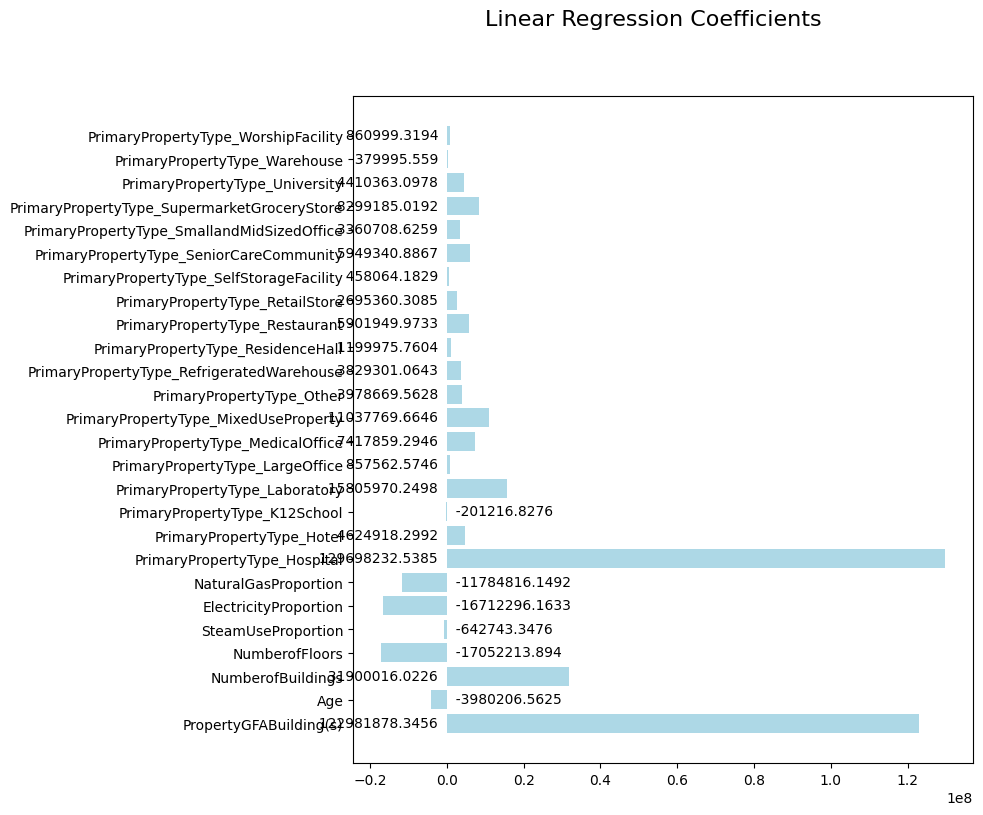

In [50]:
pipe.fit(X_train, y_train)
print('\nTest score :')
ds.score(pipe, X_test, y_test)
ds.linearRegressionSummary(pipe['linreg'], X.columns)

The regression has high variance and coefficient have huge values. 
It needs to be regularized.

Pipeline
Cross-validation evaluation results w.r.t the r2 metrics:

    scores on folds: [0.53091645 0.18610319 0.86490104 0.48832428 0.6905651 ]
    mean score: 0.5521620099494576
    std score deviation: 0.2260472548277191

Test score :
    R2 0.8817005458339673


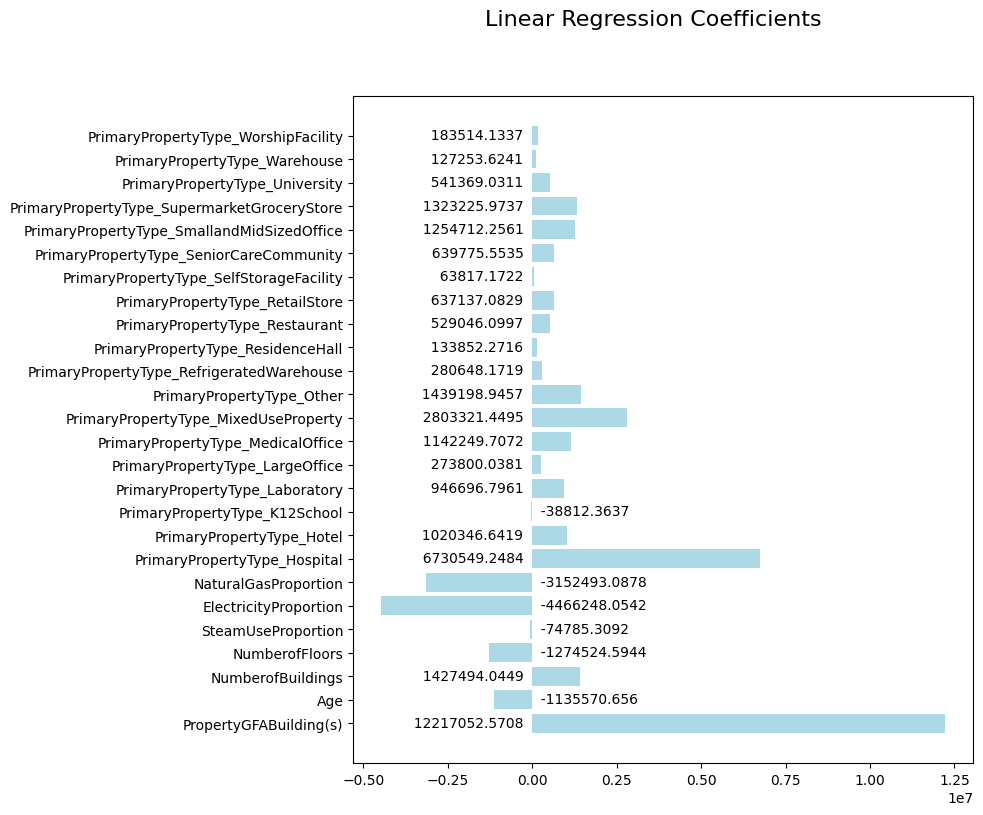

In [51]:
pipe2 = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('linreg', LinearRegression())
    ]
)

ds.CV_evaluation(pipe2, X_train, y_train, seed=0)

pipe2.fit(X_train, y_train)
print('\nTest score :')
ds.score(pipe2, X_test, y_test)
ds.linearRegressionSummary(pipe2['linreg'], X.columns)

Same with a different initial scaling

## Lasso

In [60]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler(feature_range=(0,1))),
        ('lasso', Lasso(random_state=0, max_iter=100_000))
    ]
)

alphas = np.logspace(4, 5, 100)
tuned_parameters = [{"lasso__alpha": alphas}]
n_folds = 5

clf = GridSearchCV(
    pipe,
    param_grid=tuned_parameters,
    scoring='r2'
)
clf.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

# ds.CV_evaluation(clf, X_train, y_train, seed=4)

Best parameter (CV score=0.591):
{'lasso__alpha': 73907.22033525775}


In [61]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler(feature_range=(0,1))),
        ('lasso', Lasso(alpha=73_907,random_state=0, max_iter=100_000))
    ]
)
ds.CV_evaluation(pipe['lasso'], X_train, y_train)

Lasso
Cross-validation evaluation results w.r.t the r2 metrics:

    scores on folds: [0.74970439 0.76485399 0.36725077 0.18739053 0.56619571]
    mean score: 0.527079077803702
    std score deviation: 0.22296297919358207



Test score :
    R2 0.8311818077297898


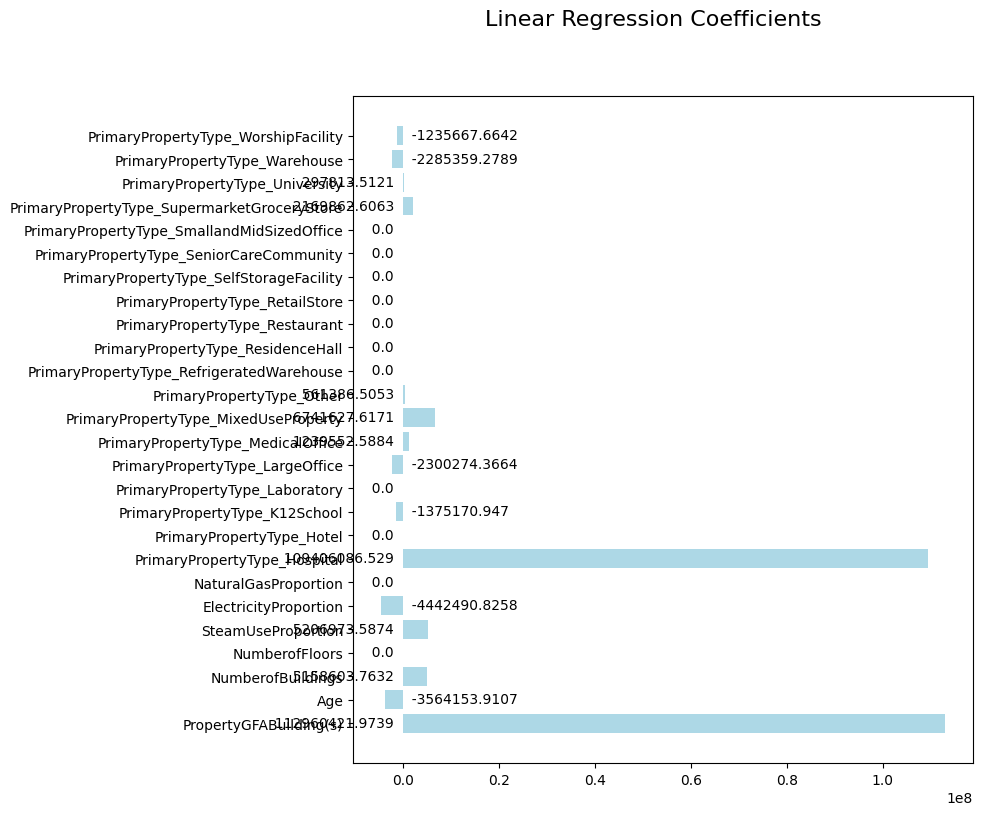

In [62]:
pipe.fit(X_train, y_train)
print('\nTest score :')
ds.score(pipe, X_test, y_test)
ds.linearRegressionSummary(pipe['lasso'], X.columns)

## Ridge

In [66]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler(feature_range=(0,1))),
        ('ridge', Ridge(random_state=0, max_iter=100_000))
    ]
)

alphas = np.logspace(-1, 0, 100)
tuned_parameters = [{"ridge__alpha": alphas}]
n_folds = 5

clf = GridSearchCV(
    pipe,
    param_grid=tuned_parameters,
    scoring='r2'
)
clf.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)


Best parameter (CV score=0.580):
{'ridge__alpha': 0.6428073117284322}


In [67]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler(feature_range=(0,1))),
        ('ridge', Ridge(alpha=0.643,random_state=0, max_iter=100_000))
    ]
)
ds.CV_evaluation(pipe['ridge'], X_train, y_train)

Ridge
Cross-validation evaluation results w.r.t the r2 metrics:

    scores on folds: [0.75671616 0.77325464 0.35872029 0.18881095 0.57319546]
    mean score: 0.5301394985004715
    std score deviation: 0.227237977701229



Test score :
    R2 0.8769405828372623


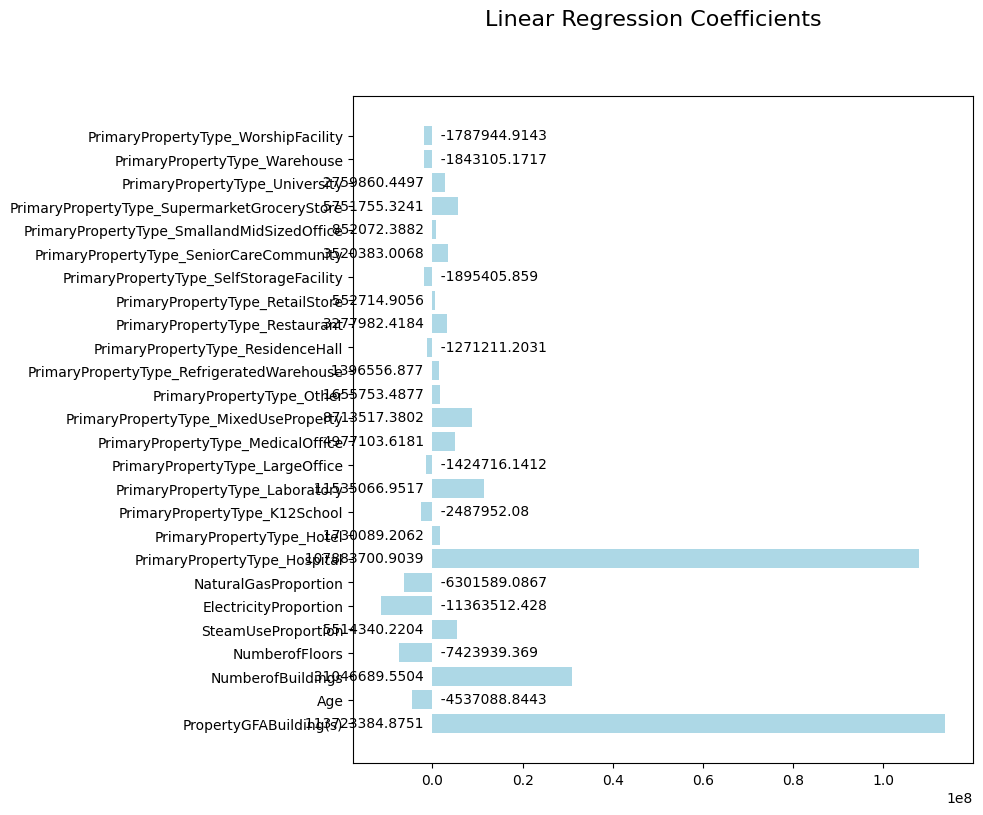

In [68]:
pipe.fit(X_train, y_train)
print('\nTest score :')
ds.score(pipe, X_test, y_test)
ds.linearRegressionSummary(pipe['ridge'], X.columns)

## Elastic-net

# Model evaluation

In [173]:
seed = 0
regressors = {
    
    'linear_regression': LinearRegression(),
    'lasso': Lasso(random_state=seed, max_iter=100_000),
    'ridge': Ridge(random_state=seed, max_iter=100_000),
    # 'elastic_net': ElasticNet(),
    # 'huber': HuberRegressor(),
    # 'knn': KNeighborsRegressor(),
    # 'random_forest': RandomForestRegressor(),
    # 'xgboost': ''

}

pre_processors = {
    
    'minmax': MinMaxScaler(feature_range=(0,1)),
    'standard': StandardScaler(),
    'robust': RobustScaler()
    
}

target_processors = {
    
    'identity': identity_transformer,
    'log_transformer': log_transformer
    
}
# A dictionary of the chosen metrics with 3 attributes:
# - the alias for some sklearn functions scoring parameter;
# - the sklearn name function;
# - eventually some kwargs to pass to the function so it has the desired
# behavior.
metrics = {
    
    'r2': {
        'scoring': 'r2' ,
        'func': r2_score,
        'kwargs': None
        },
    
    'mae': {
        'scoring': 'neg_mean_absolute_error',
        'func': mean_absolute_error,
        'kwargs': None
        },
    
    'rmse': {
        'scoring': 'neg_root_mean_squared_error' ,
        'func': mean_squared_error,
        'kwargs': dict([('squared', False)])
        }#,
    
    # 'rmsle': {'scoring': 'neg_mean_squared_log_error',
    #          'func': mean_squared_log_error,
    #          'kwargs': dict([('squared', False)])
    #          }
    
}


In [178]:
# testing rmse
met = 'rmse'
pred = pipe.predict(X_train)
tfunc = metrics[met]['func']
tkwargs = metrics[met]['kwargs']
if tkwargs is not None:
    score = tfunc(y_train, pred, **tkwargs)
else:
    score = tfunc(y_train, pred)
score

14747234.34862928

In [168]:
# Compute the cartesian product
import itertools
combinations = list(
    
    itertools.product(
        regressors.keys(),
        pre_processors.keys(),
        # target_processors.keys(),
        metrics.keys()
    )
    
)

idx = pd.MultiIndex.from_tuples(
        combinations,
    names=["regressor",
           "pre_processor",
        #    "target_processor",
           "metric"
           ]
)

cols = ['CV_train_score_mean',
        'CV_train_score_std',
        'computation_time',
        'hyperparameters',
        'CV_scores'
        'test_score']

m = idx.shape[0]
n = len(cols)
x = np.zeros(m*n).reshape(m,n)

df = pd.DataFrame(x, index=idx, columns=cols)
df

CV_train_score_mean  \
regressor         pre_processor metric                        
linear_regression minmax        r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   
                  standard      r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   
                  robust        r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   
lasso             minmax        r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   
                  standard      r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   
                  robust        r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   
ridge             minmax        r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   
                  standard      r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   
                  robust        r2                      0.0   
                                mae                     0.0   
                                rmse                    0.0   
                                msle                    0.0   

                                        CV_train_score_std  computation_time  \
regressor         pre_processor metric                                         
linear_regression minmax        r2                     0.0               0.0   
                                mae                    0.0               0.0   
                                rmse                   0.0               0.0   
                                msle                   0.0               0.0   
                  standard      r2                     0.0               0.0   
                                mae                    0.0               0.0   
                                rmse                   0.0               0.0   
                                msle                   0.0               0.0   
                  robust        r2                     0.0               0.0   
                                mae                    0.0               0.0   
                                rmse                   0.0               0.0   
                                msle                   0.0               0.0   
lasso             minmax        r2                     0.0               0.0   
                                mae                    0.0               0.0   
                                rmse                   0.0               0.0   
                                msle                   0.0               0.0   
                  standard      r2                     0.0               0.0   
                                mae                    0.0               0.0   
                                rmse         

In [128]:
df.loc[('lasso','minmax','none', 'r2'), 'hyperparameters'] = 5

/tmp/ipykernel_4942/962172260.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('lasso','minmax','none', 'r2'), 'hyperparameters'] = 5


In [117]:
with pd.option_context("display.multi_sparse", False):
    display(df)

,,,,CV_train_score_mean,CV_train_score_std,computation_time,hyperparameters,CV_scorestest_score
regressor,preprocessor,target_processor,metric,,,,,
linear_regression,minmax,none,r2,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,none,mae,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,none,rmse,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,none,rmsle,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,log_transformation,r2,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,log_transformation,mae,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,log_transformation,rmse,0.0,0.0,0.0,0.0,0.0
linear_regression,minmax,log_transformation,rmsle,0.0,0.0,0.0,0.0,0.0
linear_regression,standard,none,r2,0.0,0.0,0.0,0.0,0.0


In [119]:
df.index.levels

FrozenList([['elastic_net', 'huber', 'knn', 'lasso', 'linear_regression', 'random_forest', 'ridge', 'xgboost'], ['minmax', 'robust', 'standard'], ['log_transformation', 'none'], ['mae', 'r2', 'rmse', 'rmsle']])

In [124]:
df.loc[('ridge','minmax'), :]

/tmp/ipykernel_4942/949409612.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('ridge','minmax'), :]


CV_train_score_mean  CV_train_score_std  \
target_processor   metric                                            
none               r2                      0.0                 0.0   
                   mae                     0.0                 0.0   
                   rmse                    0.0                 0.0   
                   rmsle                   0.0                 0.0   
log_transformation r2                      0.0                 0.0   
                   mae                     0.0                 0.0   
                   rmse                    0.0                 0.0   
                   rmsle                   0.0                 0.0   

                           computation_time  hyperparameters  \
target_processor   metric                                      
none               r2                   0.0              0.0   
                   mae                  0.0              0.0   
                   rmse                 0.0              0.0   
                   rmsle                0.0              0.0   
log_transformation r2                   0.0              0.0   
                   mae                  0.0              0.0   
                   rmse                 0.0              0.0   
                   rmsle                0.0              0.0   

                           CV_scorestest_score  
target_processor   metric                       
none               r2                      0.0  
                   mae                     0.0  
                   rmse                    0.0  
                   rmsle                   0.0  
log_transformation r2                      0.0  
                   mae                     0.0  
                   rmse                    0.0  
                   rmsle                   0.0

In [126]:
# extract all with minmax (drop_level to keep it written)
df.xs('minmax', level="preprocessor", drop_level=False)

CV_train_score_mean  \
regressor         preprocessor target_processor   metric                        
linear_regression minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
lasso             minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
ridge             minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
elastic_net       minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
huber             minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
knn               minmax       none               r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
                               log_transformation r2                      0.0   
                                                  mae                     0.0   
                                                  rmse                    0.0   
                                                  rmsle                   0.0   
random_f

In [139]:
idx = df.index.get_level_values('pre_processor')[0]

KeyError: 'Level pre_processor not found'

In [ ]:
for n, idx in enumerate(df.index):
    Pipe = Pipeline(
        [
            ('pre_processor', idx.get_level_values('preprocessor')
        ]
    )

In [138]:
idx.get_level_values('preprocessor')

AttributeError: 'tuple' object has no attribute 'get_level_values'

In [142]:
a = {'a': 2, 'b':3}

In [143]:
a.keys()

dict_keys(['a', 'b'])

In [149]:
dict([('squared',False)])

{'squared': False}

In [150]:
X_train

,PropertyGFABuilding(s),Age,NumberofBuildings,NumberofFloors,SteamUseProportion,ElectricityProportion,NaturalGasProportion,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K12School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_LargeOffice,PrimaryPropertyType_MedicalOffice,PrimaryPropertyType_MixedUseProperty,PrimaryPropertyType_Other,PrimaryPropertyType_RefrigeratedWarehouse,PrimaryPropertyType_ResidenceHall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_RetailStore,PrimaryPropertyType_SelfStorageFacility,PrimaryPropertyType_SeniorCareCommunity,PrimaryPropertyType_SmallandMidSizedOffice,PrimaryPropertyType_SupermarketGroceryStore,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_WorshipFacility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,
163,61156,17,1,4,0.0,0.74,0.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,759392,54,1,41,0.3,0.68,0.02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
756,78920,94,1,4,0.0,0.86,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23689,24224,66,1,2,0.0,0.55,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27494,36982,44,1,1,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,51374,23,1,2,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
514,131387,26,1,1,0.0,0.88,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,52298,102,1,3,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


AttributeError: 'list' object has no attribute 'get'